In [2]:
## 参考自：https://blog.51cto.com/u_8238263/6170341

In [103]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import math
import matplotlib.pyplot as plt

from torch.autograd import Variable

from typing import *

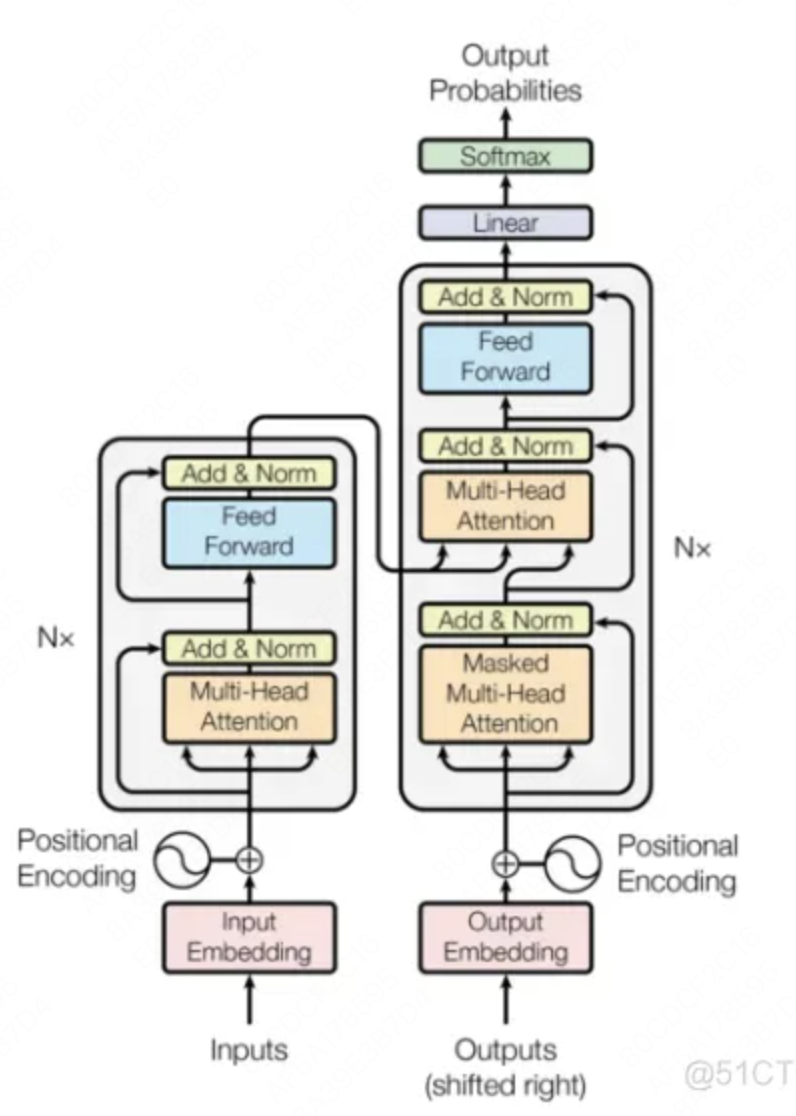

# 1 输入部分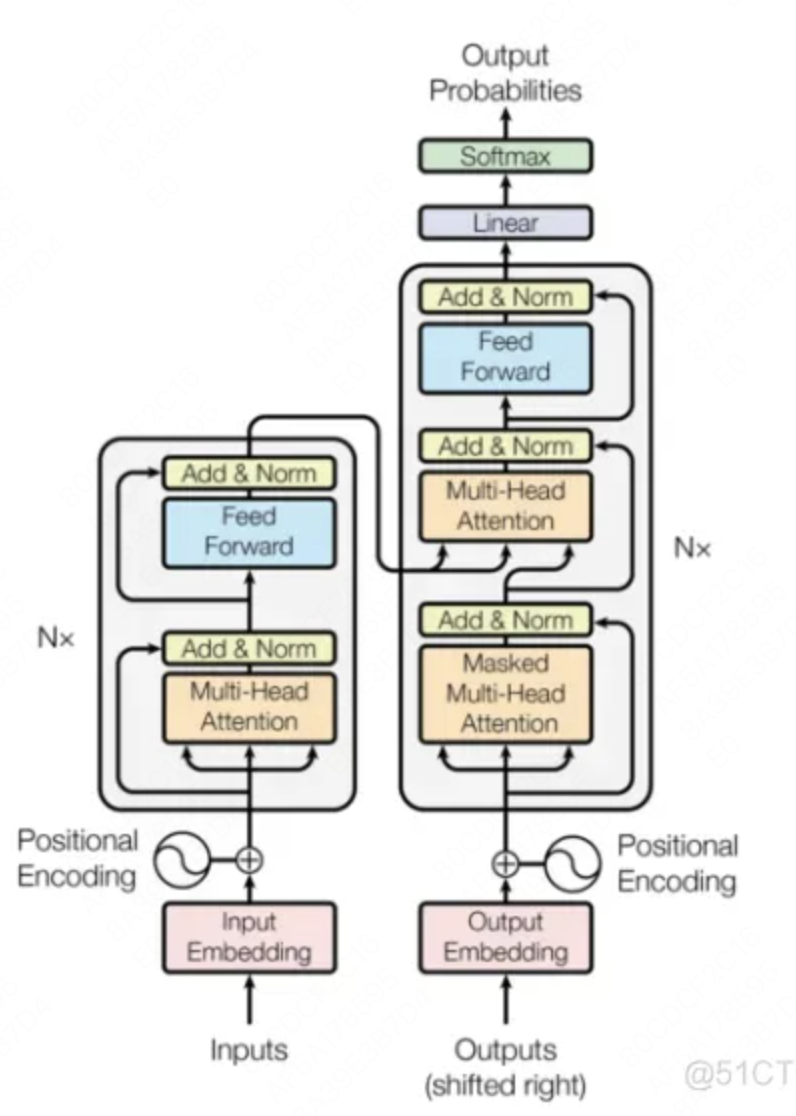

In [156]:
# 文本嵌入层
class Embeddings(nn.Module):
    
    def __init__(self, vocab_size: int, length: int):
        super(Embeddings, self).__init__()
        self.lut = nn.Embedding(vocab_size, length)
        self.length = length
    
    def forward(self, x):
        return self.lut(x) * math.sqrt(self.length)

    
# 位置编码器
class PositionalEncoding(nn.Module):
    
    def __init__(self, length: int, dropout: float, max_len: int = 5000):
        """
        @param length: 词向量长度
        """
        
        super(PositionalEncoding, self).__init__()
        
        self.dropout = nn.Dropout(p=dropout)
        
        # 初始 0矩阵  max_len * length
        pe = torch.zeros(max_len, length)
        
        # max_len * 1
        position = torch.arange(0, max_len)[:, None]
        
        # 希望它能够将自然数的绝对位置编码缩放成足够小的数字
        div_term = torch.exp(torch.arange(0, length, 2) * (-math.log(10000.0) / length))
        # 偶数位置分布在正弦波上，奇数位置分布在余弦波上，最终填充在pe上
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        
        # 需要与词嵌入向量（3维）相加，需要扩展维度  1 * max_len * length
        pe = pe[None, :]
        
        # 将pe注册为模型buffer（非参数或超参数，不需要随着优化步骤更新）
        self.register_buffer("pe", pe)
    
    def forward(self, x):
        """x为文本序列的词向量"""
        # pe切片，保证与词序列长度相同；且不需要梯度优化更新
        x = x + Variable(self.pe[:, :x.shape[1]], requires_grad=False)
        return self.dropout(x)

## 绘制词汇向量中位置特征的分布曲线

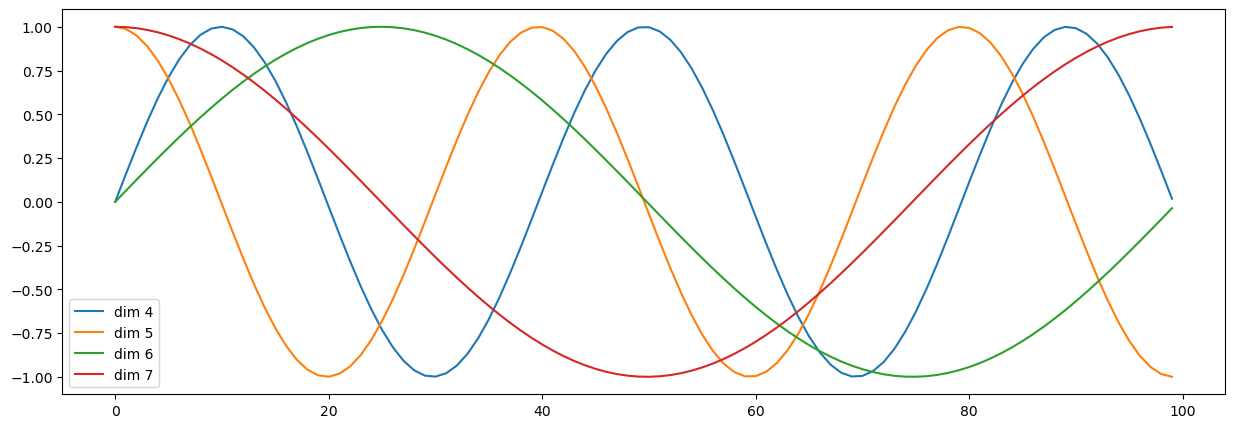

In [61]:
length = 20
word_length = 100
p = PositionalEncoding(length, drop_out=0)

word_vec = torch.zeros(1, word_length, length)
y = p(word_vec)   # 1 * word_length * length

plt.figure(figsize=(15, 5))
plt.plot(np.arange(word_length), y[0, :, 4:8].data.numpy())
plt.legend([f"dim {x}" for x in [4, 5, 6, 7]])

# 2 编码器部分

In [84]:
# 生成掩码向量，防止attention中张量计算时使用到未来信息
# 训练时会用到未来信息，但是理论上解码输出时只能通过上一次结果来产生，因此需要防止未来信息被提前利用。
def subsequent_mask(size: int) -> torch.Tensor:
    """生成向后遮掩的掩码向量，最后两维形成方阵"""
    attn_shape = (1, size, size)
    
    # 生成下三角阵，最终让右上角（不含对角线）为0  （左为前，右为后）
    # 最后为了节约内存，将数据类型变为uint8
    mask = 1 - np.triu(np.ones(attn_shape, dtype="uint8"), k=1)
    return torch.from_numpy(mask)

In [85]:
subsequent_mask(5)

tensor([[[1, 0, 0, 0, 0],
         [1, 1, 0, 0, 0],
         [1, 1, 1, 0, 0],
         [1, 1, 1, 1, 0],
         [1, 1, 1, 1, 1]]], dtype=torch.uint8)

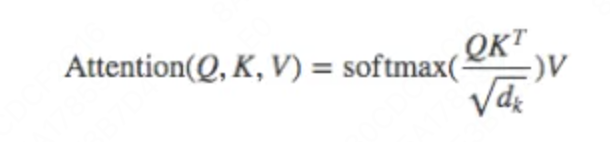

## 2.1 注意力机制

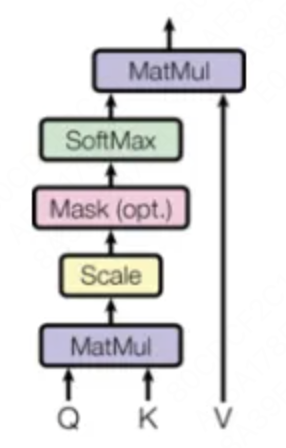

In [153]:
def attention(query: torch.Tensor, key: torch.Tensor, value: torch.Tensor, 
              mask: torch.Tensor = None, dropout: nn.Dropout = None):
    """注意力机制的实现"""
    
    # 取最后一维，即词向量长度
    dk = query.size(-1)
    # 转置后两维，也称缩放点注意力计算
    # scores形状 [B, S, S]
    scores = torch.matmul(query, key.transpose(-2, -1)) / math.sqrt(dk)
    if mask is not None:
        # 掩码为0对应的scores张量设为1e-9
        scores = scores.masked_fill(mask==0, value=1e-9)
    
    # 对scores最后一维进行softmax
    p_attn = F.softmax(scores, dim=-1)    # [B, S, S]
    
    if dropout is not None:
        p_attn = dropout(p_attn)
    
    attn = torch.matmul(p_attn, value)    # [B, S, D]
    
    # 同时返回注意力表达和注意力张量
    return attn, p_attn

## 2.2 多头注意力

In [107]:
from copy import deepcopy

In [109]:
# 定义clone函数，因为多头注意力中会用到多个相同结构的线性层
def clones(module: nn.Module, n: int) -> nn.ModuleList:
    return nn.ModuleList([deepcopy(module) for _ in range(n)])

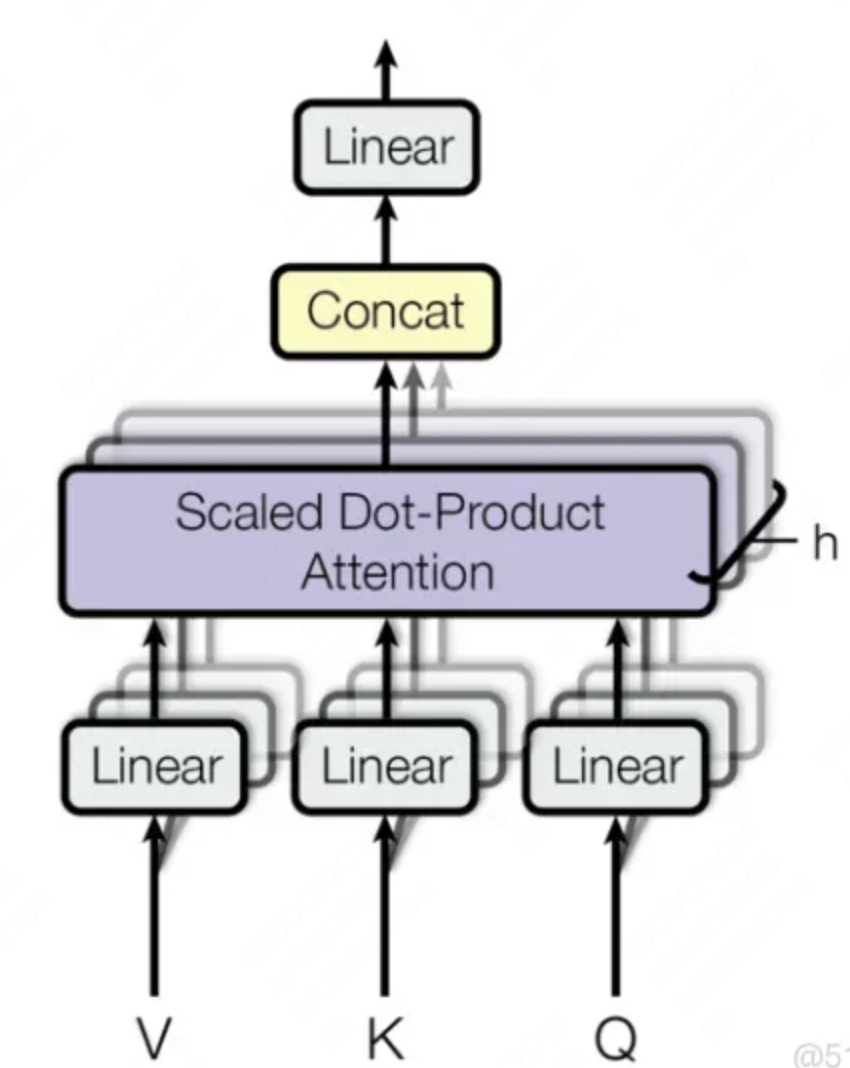

In [145]:
class MultiHeadedAttention(nn.Module):
    
    def __init__(self, h: int, embedding_length: int, dropout: float = 0.1):
        """
        @param h: 头数
        @param embedding_length: 词向量长度
        """
        super(MultiHeadedAttention, self).__init__()
        
        # 多头一定可以整除切分
        assert embedding_length % h == 0
        
        # 每个头可以获得的词向量长度
        self.dk = embedding_length // h
        self.h = h
        
        # 获取线性变化层对象，因为不改变形状，所以线性层参数形状为 (embedding_length, embedding_length)
        # 需要clone 4 个， Q、K、V各一个，然后最后拼接的矩阵还需要一个
        self.linears = clones(nn.Linear(embedding_length, embedding_length), 4)
        
        # 代表最终获得的注意力张量，还未计算初始化为 None
        self.attn = None
        
        self.dropout = nn.Dropout(dropout)
    
    def forward(self, query, key, value, mask=None):
        
        if mask is not None:
            mask = mask[None, :]
        
        # 获得样本数量
        batch_size = query.size(0)
        
        # 多头处理，最后一维切成多头，h * dk => [B, S, h, dk]
        # 对第2和第3维进行转置，是为了让代表句子长度的维度 S 和词向量维度 dk挨在一起
        # 从而与正规输入attention的张量（只用到最后两维）维度意义保持一致
        # 最终输出张量形状: [B, h, S, dk]
        query, key, value = [model(x).view(batch_size, -1, self.h, self.dk).transpose(1, 2) 
                             for model, x in zip(self.linears[:3], (query, key, value))]
        
        # 传入attention中
        # 注意力输出张量 x形状：[B, h, S, dk]
        # self.attn形状：[B, h, S, S]
        x, self.attn = attention(query, key, value, mask, self.dropout)
        
        # 从多头恢复，需要将维度重新转置回来，重塑形状
        # 需要用contiguous方法让张量内存排布适应当前形状
        # [B, h, S, dk] => [B, S, h, dk] => [B, S, h * dk] = [B, S, embedding_length]
        x = x.transpose(1, 2).contiguous().view(batch_size, -1, self.h * self.dk)
        
        # 最后使用最后一个线性层做输出
        return self.linears[-1](x)

## 2.3 前馈全连接层

In [152]:
# 具有两层线性层的全连接网络
# 考虑纯注意力机制可能对复杂过程的拟合不够，需要增加两层全连接网络增强模型能力

class FeedForward(nn.Module):
    
    def __init__(self, n_input: int, hidden_size: int, dropout: float = 0.1):
        
        super(FeedForward, self).__init__()
        
        self.w1 = nn.Linear(n_input, hidden_size)
        self.w2 = nn.Linear(hidden_size, n_input)
        
        self.dropout = nn.Dropout(dropout)
    
    def forward(self, x):
        x = self.w1(x)
        x = F.relu(x)
        x = self.dropout(x)
        return self.w2(x)

## 2.4 规范化层

In [147]:
# transformer中采用的规范化是 LayerNorm 而不是 BatchNorm

class LayerNorm(nn.Module):
    
    def __init__(self, n_features, eps: float = 1e-6):
        """
        @param n_features: 表示特征数量（词向量长度）
        @param eps: 防止标准差分母为0
        """
        super(LayerNorm, self).__init__()
        
        # 初始化norm参数，斜率为1，截距为0
        self.a = nn.Parameter(torch.ones(n_features))
        self.b = nn.Parameter(torch.zeros(n_features))
        self.eps = eps
    
    def forward(self, x: torch.Tensor):
        mean = x.mean(dim=-1, keepdim=True)
        std = x.std(dim=-1, keepdim=True)
        return self.a * (x - mean) / (std + self.eps) + self.b

## 2.5 子层连接结构

In [149]:
# 输入到子层和规范化层的过程中，采用了残差连接的方式

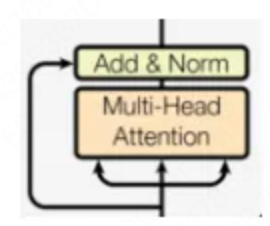
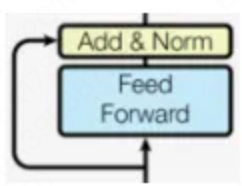

In [150]:
class SubLayerConnection(nn.Module):
    
    def __init__(self, size: int, dropout: float = 0.1):
        """
        @param size: 词向量长度
        """
        super(SubLayerConnection, self).__init__()
        self.dropout = nn.Dropout(dropout)
        self.norm = LayerNorm(size)
    
    def forward(self, x: torch.Tensor, sublayer: nn.Module):
        # 采用的是pre-norm，即先norm再进入sublayer
        # t = self.dropout(sublayer(self.norm(x)))
        # return x + t
        
        # 采用post-norm，即sublayer后再做norm，传统transformer做法
        return self.norm(x + self.dropout(sublayer(x)))

## 2.6 编码器层

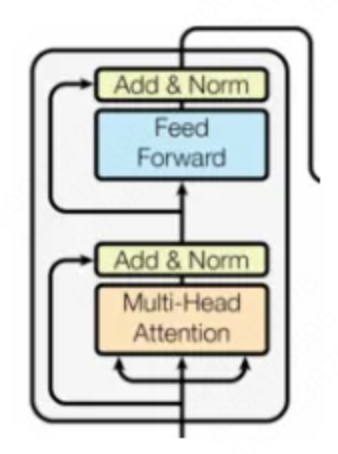

In [175]:
class EncoderLayer(nn.Module):
    
    def __init__(self, size: int, h: int, hidden_size: int, dropout: float):
        """
        @param h: 多头自注意力机制的头数
        @param feed_forward: 前馈全连接层实例化对象
        """
        super(EncoderLayer, self).__init__()
        self.attn = MultiHeadedAttention(h, size, dropout)
        self.feed_forward = FeedForward(size, hidden_size, dropout)
        
        # 一个编码器有两个子层结构
        sublayer = SubLayerConnection(size, dropout)
        self.sublayers = clones(sublayer, 2)
        self.size = size
    
    def forward(self, x, mask):
        x = self.sublayers[0](x, lambda x: self.attn(x, x, x, mask))    # 多头自注意力
        x = self.sublayers[1](x, self.feed_forward)
        return x

## 2.7 编码器

In [181]:
# 由 n个编码器层堆叠而成

class Encoder(nn.Module):
    
    def __init__(self, encoder_layer: EncoderLayer, n: int):
        super(Encoder, self).__init__()
        self.layers = clones(encoder_layer, n)
    
    def forward(self, x, mask):
        for layer in self.layers:
            x = layer(x, mask)
        return x

In [182]:
b = 2
s = 4
d = 512
h = 8
vocab_size = 1000
hidden_size = 64
dropout = 0.2
N = 8

emb = Embeddings(vocab_size, length=d)
pe = PositionalEncoding(d, dropout=0, max_len=5000)
mask = Variable(torch.zeros(h, s, s))
encoder_layer = EncoderLayer(size=d, h=h, hidden_size=hidden_size, dropout=dropout)

In [186]:
x = torch.LongTensor([[100, 2, 421, 508], [491, 998, 1, 221]])   # [B, S]
embr = emb(x)            # [B, S, D]
pe_result = pe(embr)     # [B, S, D]

encoder = Encoder(encoder_layer, N)
en_result = encoder(pe_result, mask)      # [B, S, D]
en_result

tensor([[[ 0.0521,  0.1205, -1.6558,  ..., -0.3708, -1.0874, -1.0605],
         [-0.0288,  0.3115, -1.6169,  ..., -0.6048,  0.2957, -0.2312],
         [ 0.5517,  0.0323, -1.6664,  ..., -1.5772, -0.1938, -0.3573],
         [-0.4587, -0.7105, -2.1369,  ..., -0.8491, -0.8555, -0.7846]],

        [[ 0.1916,  0.1736, -0.6090,  ..., -1.2997, -0.2434,  0.2421],
         [ 0.6326,  1.8165, -0.9673,  ..., -1.0490, -0.2891,  0.1376],
         [ 0.4027,  1.1546, -1.2690,  ..., -0.4328, -0.4906,  0.6922],
         [-0.0196,  0.9637, -0.1185,  ..., -1.3446,  0.5056,  0.2015]]],
       grad_fn=<AddBackward0>)

In [188]:
en_result.shape

torch.Size([2, 4, 512])

# 3 解码器部分

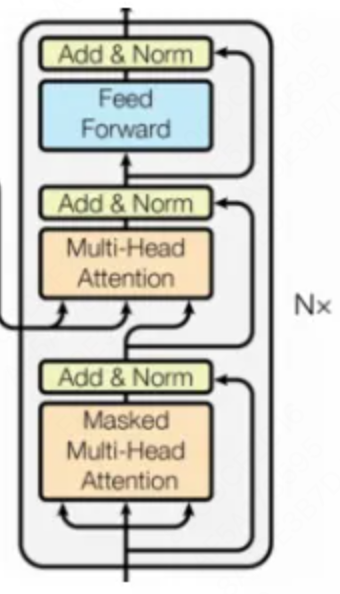

## 3.1 解码器层

In [189]:
class DecoderLayer(nn.Module):
    
    def __init__(self, size: int, h: int, hidden_size: int, dropout: float):
        super(DecoderLayer, self).__init__()
        
        self.size = size
        # 第一个是自注意力，第二个不是
        self.self_attn, self.src_attn = clones(MultiHeadedAttention(h, size, dropout), 2)
        self.feed_forward = FeedForward(size, hidden_size, dropout)
        self.sublayers = clones(SubLayerConnection(size, dropout), 3)
    
    def forward(self, x, memory, source_mask, target_mask):
        """
        @param x: 上一层输入
        @param memory: 编码器输入
        @param source_mask: 源数据掩码
        @param target_mask: 目标数据掩码
        """
        m = memory
        # target_mask遮掩未来信息，抑制信息泄漏
        x = self.sublayers[0](x, lambda x: self.self_attn(x, x, x, target_mask))
        
        # source_mask遮蔽掉对输出结果无帮助的字符产生的自注意力
        x = self.sublayers[1](x, lambda x: self.src_attn(x, m, m, source_mask))
        
        x = self.sublayers[2](x, self.feed_forward)
        return x

## 3.2 解码器

In [191]:
class Decoder(nn.Module):
    
    def __init__(self, decoder_layer: DecoderLayer, n: int):
        super(Decoder, self).__init__()
        self.layers = clones(decoder_layer, n)
    
    def forward(self, x, memory, source_mask, target_mask):
        
        for layer in self.layers:
            x = layer(x, memory, source_mask, target_mask)
        return x

# 4 输出部分

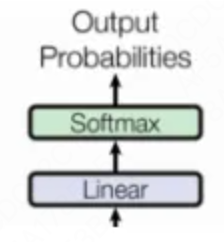

In [202]:
class Generator(nn.Module):
    
    def __init__(self, size: int, vocab_size: int):
        """
        @param size: 词向量长度
        @param vocab_size: 词表长度
        """
        super(Generator, self).__init__()
        self.project = nn.Linear(size, vocab_size)
    
    def forward(self, x):
        return F.log_softmax(self.project(x), dim=-1)

# 5 模型构建

In [203]:
class EncoderDecoder(nn.Module):
    
    def __init__(self, encoder: Encoder, decoder: Decoder, source_emb: nn.Module, target_emb: nn.Module, generator: Generator):
        """
        @param encoder: 编码器模块
        @param decoder: 解码器模块
        @param source_emb: 源数据向量化模块
        @param target_emb: 目标数据向量化模块
        @param generator: 最终输出模块
        """
        super(EncoderDecoder, self).__init__()
        
        self.encoder = encoder
        self.decoder = decoder
        self.source_emb = source_emb
        self.target_emb = target_emb
        self.generator = generator
    
    def forward(self, source, target, source_mask, target_mask):
        m = self.encode(source, source_mask)
        return self.decode(target, m, source_mask, target_mask)
    
    def encode(self, source, source_mask):
        return self.encoder(self.source_emb(source), source_mask)
    
    def decode(self, target, memory, source_mask, target_mask):
        return self.decoder(self.target_emb(target), memory, source_mask, target_mask)

In [211]:
def make_model(source_vocab: int, target_vocab: int, head: int = 8, n: int = 6, 
               size: int = 512, hidden_size: int = 2048, dropout: float = 0.1):
    """
    @param source_vocab: 源数据词汇总数
    @param target_vocab: 目标词汇总数
    @param head: 多头注意力的头数
    @param n: 堆叠数
    @param size: 词向量长度
    @param hidden_size: 全连接层参数
    @param dropout: dropout置0比率
    """
    
    # source-emb
    source_emb = nn.Sequential(Embeddings(source_vocab, size), PositionalEncoding(size, dropout))
    
    # target-emb
    target_emb = nn.Sequential(Embeddings(target_vocab, size), PositionalEncoding(size, dropout))
    
    # 编码器类
    encoder = Encoder(EncoderLayer(size, head, hidden_size, dropout), n)
    
    # 解码器类
    decoder = Decoder(DecoderLayer(size, head, hidden_size, dropout), n)
    
    # 输出类
    generator = Generator(size, target_vocab)
    
    # transformer模型
    model = EncoderDecoder(encoder, decoder, source_emb, target_emb, generator)
    
    # 初始化参数
    for p in model.parameters():
        if p.dim() > 1:
            nn.init.xavier_uniform_(p)
    
    return model

In [212]:
source_vocab = 11
target_vocab = 11
n = 6

model = make_model(source_vocab, target_vocab, n=n)
model

EncoderDecoder(
  (encoder): Encoder(
    (layers): ModuleList(
      (0): EncoderLayer(
        (self_attn): MultiHeadedAttention(
          (linears): ModuleList(
            (0): Linear(in_features=512, out_features=512, bias=True)
            (1): Linear(in_features=512, out_features=512, bias=True)
            (2): Linear(in_features=512, out_features=512, bias=True)
            (3): Linear(in_features=512, out_features=512, bias=True)
          )
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (feed_forward): FeedForward(
          (w1): Linear(in_features=512, out_features=2048, bias=True)
          (w2): Linear(in_features=2048, out_features=512, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (sublayers): ModuleList(
          (0): SubLayerConnection(
            (dropout): Dropout(p=0.1, inplace=False)
            (norm): LayerNorm()
          )
          (1): SubLayerConnection(
            (dropout): Dropout(p=0.1, inplac

# 6 “COPY”任务学习